In [1]:
import os
import time
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys
sys.path.insert(0, os.path.abspath("../function"))
from ART_preprocessing import haversine, create_box
from ART_plot import plot_neighborhood, plot_scales_aggregation

import warnings
warnings.filterwarnings('ignore')

In [2]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')
data_dir = os.path.join(dir_base,'IMERG','3_hour',f'IMERG_Veneto_3h_2001_01_01_2023_12_31_025x025.nc')

if os.path.exists(data_dir):
    DATA = xr.open_dataset(data_dir)
    # DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))
else:
    raise SystemExit(f"File not found: {data_dir}")

# The first row and last column are NaN maybe were be created in the CDO agregations 
lat_min, lat_max, lon_min, lon_max = 44, 47, 10, 14
DATA = DATA.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

lats = DATA['lat'].data
lons = DATA['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

year_vector = np.unique(pd.to_datetime(DATA['time']).year)

PRE = DATA['PRE'].values

DATES = DATA['time'][:]

DATA

<xarray.Dataset> Size: 104MB
Dimensions:  (time: 67200, lon: 16, lat: 12)
Coordinates:
  * time     (time) datetime64[ns] 538kB 2001-01-01 ... 2023-12-31T21:00:00
  * lon      (lon) float32 64B 10.12 10.38 10.62 10.88 ... 13.38 13.62 13.88
  * lat      (lat) float32 48B 44.12 44.38 44.62 44.88 ... 46.38 46.62 46.88
Data variables:
    PRE      (time, lat, lon) float64 103MB 0.01125 0.0 0.825 ... 27.53 29.24
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    description:  IMERG 3 hour data for Veneto region
    history:      Tue Nov 12 09:42:36 2024: cdo remapbil,TRMM_Veneto_3h_1998_...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [3]:
x = da.from_array(PRE, chunks=(300, 12, 16))
xrs0 = xr.DataArray(x,  coords={'time':pd.to_datetime(DATA['time']), 'lat':lats, 'lon':lons},
                                                    dims=('time','lat','lon'))
xrs0

<xarray.DataArray 'array-e8ad3ac242cc9d78f3e7c5e3859386f8' (time: 67200,
                                                            lat: 12, lon: 16)> Size: 103MB
dask.array<array, shape=(67200, 12, 16), dtype=float64, chunksize=(300, 12, 16), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 538kB 2001-01-01 ... 2023-12-31T21:00:00
  * lat      (lat) float32 48B 44.12 44.38 44.62 44.88 ... 46.38 46.62 46.88
  * lon      (lon) float32 64B 10.12 10.38 10.62 10.88 ... 13.38 13.62 13.88

In [4]:
PARAM = dict({
    'L1':25,
    'origin_x': 25,
    'radio':0.3,
    'npix':3,
    'thresh': 1,

    'maxmiss':40,
    'condition': 'OVERLEAP',

    'L0':0,
    'tmax': 48,
    'dt': 3,

    'origin_t': 24,
    'target_x': 0,
    'target_t': 24,

    'ninterp':2000,

    'acf': 'mar',
    'corr_method':'pearson',
    'cores': 12,
})

In [5]:
def my_function(data):
    if isinstance(data, xr.DataArray):
        print('DataArray')
    elif isinstance(data, xr.Dataset):
        print('Dataset')

In [6]:
clat = lats[5]
clon = lons[6]

In [7]:
lats = xrs0['lat']
lons = xrs0['lon']
time_vector = xrs0['time']
xrs = xrs0.where(xrs0 >= -0.001)

In [8]:
buffer = 0.5*PARAM['npix']*PARAM['radio'] # To define the limitis of box_3h
eps = 1e-4 # to make sure to include limtis -> add an eps buffer
solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))

In [9]:
box_3h = xrs.where(bcond, drop = True).load()

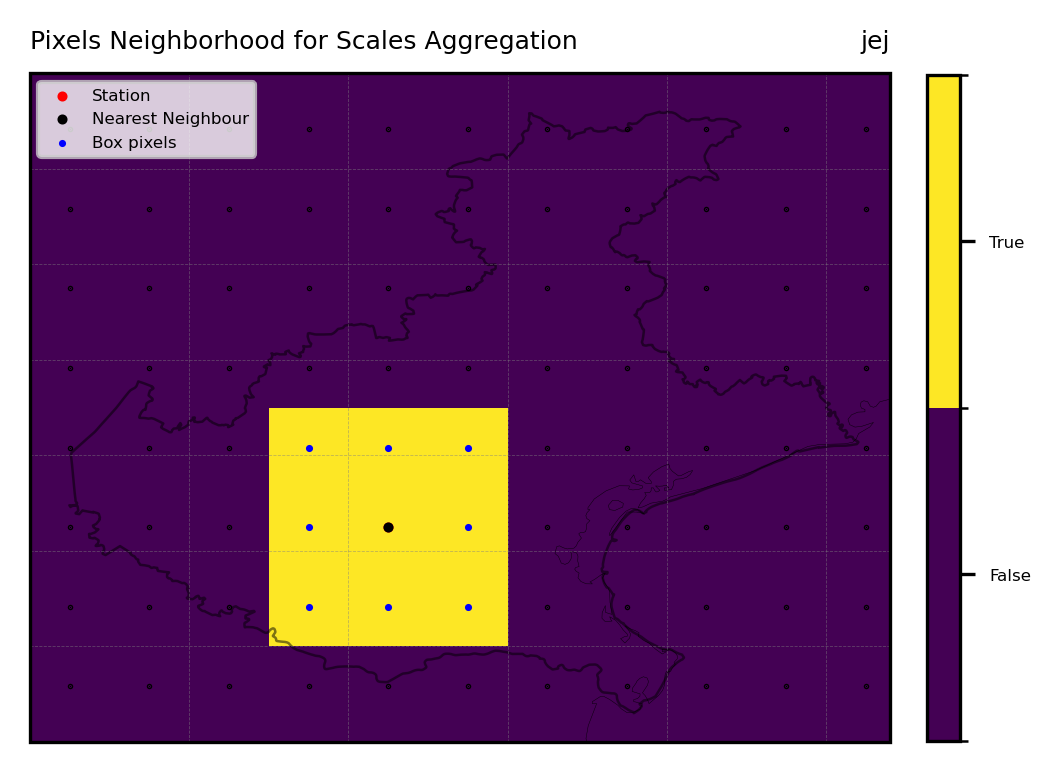

In [10]:
plot_neighborhood(box_3h, lon2d, lat2d, bcond, (clat,clon), (clat,clon), 'jej', 'jeje', save=False)

## Box_3h Agregations

In [11]:
nlon = len(box_3h['lon'].data)
nlat = len(box_3h['lat'].data)

In [12]:
CONDITION = PARAM['condition']

In [13]:
def wetfrac(array, thresh):
    '''
    Calcula la fraccion de humedad de una serie de tiempo de lluvia (wetfraction)
    Definida como el numero de dias superiores al threshold dividido entre el total de dias
    Por tanto obtenemos la fraccion de humedad en un determinado periodo
    '''
    return np.size(array[array > thresh])/np.size(array)

def space_time_scales_agregations(box_3h, L1, CONDITION, tscales, xscales, npix, thresh):
    rainfall_ref = []
    Swet_final = []
    Swet_scale = []

    for st in tscales:
        datamat = box_3h.resample(time='{}h'.format(st)).sum(dim='time', skipna = False)
        input_data = datamat.copy()

        for ix, sx in enumerate(xscales):
            if sx == 1:
                wet_tmp = np.apply_along_axis(wetfrac, axis=0, arr=input_data.data, thresh=thresh)
                Swet_final.append(wet_tmp.mean())
                Swet_scale.append(L1)

            elif sx == smax:
                wet_tmp = wetfrac(input_data.mean(axis=(1, 2)).data, thresh)
                Swet_final.append(wet_tmp)
                Swet_scale.append(L1*smax)

            else:
                Swet_fraction = []

                for i in range(nlat):
                    for j in range(nlon):
                        box_tmp = input_data[:,i:i+sx,j:j+sx]

                        if box_tmp.shape[1] == sx and box_tmp.shape[2] == sx:
                            wet_tmp = wetfrac(box_tmp.mean(axis=(1,2)).data, thresh)
                            Swet_fraction.append(wet_tmp)

                Swet_final.append(np.mean(Swet_fraction)) # wet fraction
                Swet_scale.append(L1*sx) # Spatial scales

    WET_MATRIX = np.reshape(Swet_final,(len(tscales),npix))

    return WET_MATRIX

In [14]:
from scipy.interpolate import interp1d, RBFInterpolator

def interpolate_wet_matrix(wet_matrix, tscales, ninterp):
    """
    Interpola la matriz WET_MATRIX para crear más puntos en la escala temporal.
    """
    tscales_inter = np.linspace(np.min(tscales), np.max(tscales), ninterp)
    # Interpolación vectorizada para todas las columnas
    interp_func = interp1d(tscales, wet_matrix, axis=0, kind='linear', fill_value="extrapolate")
    wet_matrix_inter = interp_func(tscales_inter)
    return wet_matrix_inter, tscales_inter

def wet_matrix_extrapolation(WET_MATRIX, spatial_scale, temporal_scale, L1, npix):
    # Create a grid of points for the original data
    original_points = np.array(np.meshgrid(temporal_scale, spatial_scale)).T.reshape(-1, 2)
    wet_fraction_values = WET_MATRIX.ravel()

    # Use RBFInterpolator for cubic extrapolation
    interpolator = RBFInterpolator(original_points, wet_fraction_values, kernel='cubic')

    # New spatial scale with 100 values from 0 to 50 km 
    new_spatial_scale = np.linspace(0, npix * L1, 100)

    # Create new grid for extrapolated data
    new_spatial, new_temporal = np.meshgrid(new_spatial_scale, temporal_scale)

    # Combine the spatial and temporal scales for interpolation
    points_to_interpolate = np.array([new_temporal.ravel(), new_spatial.ravel()]).T

    # Get the interpolated values (including extrapolated values)
    WET_MATRIX_EXTRA = interpolator(points_to_interpolate).reshape(new_temporal.shape)
    
    return WET_MATRIX_EXTRA, new_spatial_scale


In [15]:
def compute_beta(WET_MATRIX_EXTRA, origin, target, new_spatial_scale, tscales_INTER):
    pos_xmin_origin = np.searchsorted(new_spatial_scale, origin[0])
    pos_tmin_origin = np.searchsorted(tscales_INTER, origin[1])

    pwet_origin = WET_MATRIX_EXTRA[pos_tmin_origin, pos_xmin_origin]

    pos_xmin_target = np.searchsorted(new_spatial_scale, target[0])
    pos_tmin_target = np.searchsorted(tscales_INTER, target[1])

    pwet_target = WET_MATRIX_EXTRA[pos_tmin_target, pos_xmin_target]

    beta = pwet_origin / pwet_target
    return beta

In [16]:
smax = box_3h.shape[1] # max spatial scale
tscales = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 36, 48, 96])*PARAM['dt']
tscales = tscales[tscales < PARAM['tmax'] + 0.001]
xscales = np.arange(1, smax+1)
xscales_km = xscales*PARAM['L1']
ntscales = np.size(tscales)
nxscales = np.size(xscales)

In [17]:
print('WET FRACTION')
start_time = time.time()
WET_MATRIX = space_time_scales_agregations(
                            box_3h, PARAM['L1'], 
                            CONDITION, 
                            tscales, 
                            xscales, 
                            PARAM['npix'], 
                            PARAM['thresh'])
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

WET FRACTION
Elapsed time: 7.62 seconds


In [18]:
print('BETA PARAMETER')
start_time = time.time()
WET_MATRIX_INTER, tscales_INTER = interpolate_wet_matrix(
                WET_MATRIX, 
                tscales, 
                PARAM['ninterp'])

WET_MATRIX_EXTRA, xscales_EXTRA = wet_matrix_extrapolation(
                WET_MATRIX_INTER, 
                xscales_km, 
                tscales_INTER, 
                PARAM['L1'], 
                PARAM['npix'])
end_time = time.time()
elapsed_time = end_time - start_time

origin_ref = [PARAM['origin_x'], PARAM['origin_t']]
target_ref = [PARAM['target_x'], PARAM['target_t']]
beta = compute_beta(WET_MATRIX_EXTRA, origin_ref, target_ref, xscales_EXTRA, tscales_INTER)
print(f"Elapsed time: {elapsed_time:.2f} seconds")
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

BETA PARAMETER
Elapsed time: 11.44 seconds
Elapsed time: 11.44 seconds


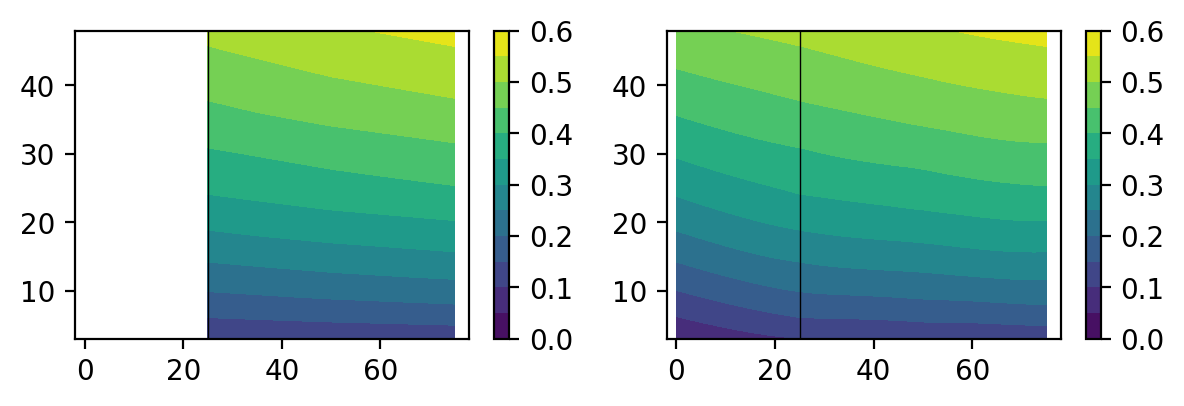

In [19]:
levels = np.arange(0,0.65,0.05)

xs, ts = np.meshgrid(xscales_km, tscales_INTER)
xsn, tsn = np.meshgrid(xscales_EXTRA, tscales_INTER)

fig = plt.figure(figsize=(7,2),dpi=200)
gs = gridspec.GridSpec(1,2)

ax1 = plt.subplot(gs[0, 0])
a1 = ax1.contourf(xs,ts,WET_MATRIX_INTER, levels=levels)
ax1.axvline(x=25, color='k', linestyle='-', linewidth=0.5)
ax1.set_xlim(-2,78)
plt.colorbar(a1)

ax1 = plt.subplot(gs[0, 1])
a1 = ax1.contourf(xsn,tsn,WET_MATRIX_EXTRA, levels=levels)
ax1.axvline(x=25, color='k', linestyle='-', linewidth=0.5)
ax1.set_xlim(-2,78)
plt.colorbar(a1)

In [20]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

def autocorrelation_neighborhood(box_3h, t_target, thresh, cor_method = 'spearman'):

    xdaily = box_3h.resample(time ='{}h'.format(t_target)).sum(dim='time', skipna=False).dropna(dim='time', how='any')
    lats = xdaily.dropna(dim='time', how='any').lat.values
    lons = xdaily.dropna(dim='time', how='any').lon.values
    nlats = np.size(lats)
    nlons = np.size(lons)
    nelem = nlats*nlons
    lats9 = np.repeat(lats, nlons)
    lons9 = np.tile(lons, nlats)

    ncorr = (nelem)*(nelem - 1)//2
    vdist = np.zeros(ncorr)
    count = 0

    vcorr = np.zeros(ncorr)

    for i in range(nelem):
        tsi = xdaily.dropna(dim='time', how='any').loc[dict(lat=lats9[i], lon=lons9[i])].values
        tsi = np.maximum(tsi-thresh, 0.0)
        for j in range(i+1, nelem):
            tsj = xdaily.dropna(dim='time', how='any').loc[dict(lat=lats9[j], lon=lons9[j])].values
            tsj = np.maximum(tsj-thresh, 0.0)
            vdist[count] = haversine(lats9[i], lons9[i], lats9[j], lons9[j])
            if cor_method == 'spearman':
                vcorr[count], _ = spearmanr(tsi, tsj)
            elif cor_method == 'pearson':
                vcorr[count], _ = pearsonr(tsi, tsj)
            count = count + 1

    distance_vector = np.linspace(np.min(vdist), np.max(vdist), 40)

    return vdist, vcorr, distance_vector

In [21]:
print('AUTOCORRELATION')
start_time = time.time()
vdist, vcorr, distance_vector = autocorrelation_neighborhood(
                box_3h, 
                t_target = PARAM['target_t'], 
                thresh = PARAM['thresh'], 
                cor_method = PARAM['corr_method'])
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

AUTOCORRELATION
Elapsed time: 0.37 seconds


In [22]:
def cluster_and_average(vdist, vcorr, toll_cluster=0.5):
    """
    Clusters the correlation data based on distances and computes average values for each cluster.
    
    Parameters:
    vdist (array): Sorted array of distances.
    vcorr (array): Sorted array of correlation values corresponding to the distances.
    toll_cluster (float): Threshold for clustering based on distance difference.

    Returns:
    vdist_ave (array): Average distance for each cluster.
    vcorr_ave (array): Average correlation for each cluster.
    nclust (int): Number of clusters.
    """
    # Sort distance and correlation
    vdist_sorted = np.sort(vdist)  # Order distance
    vcorr_sorted = vcorr[np.argsort(vdist)]  # Order correlation in relation to distance

    # Initialize cluster assignments
    cluster = np.zeros(len(vdist_sorted))
    count = 0
    
    # Clustering based on distance
    for i in range(1, len(vdist_sorted)):
        if np.abs(vdist_sorted[i] - vdist_sorted[i - 1]) < toll_cluster:
            cluster[i] = count
        else:
            count += 1
            cluster[i] = count

    # Extract unique clusters
    clust = set(cluster)
    nclust = len(clust)  # Number of clusters

    # Initialize arrays for average distance and correlation
    vdist_ave = np.zeros(nclust)
    vcorr_ave = np.zeros(nclust)
    
    # Compute average distance and correlation for each cluster
    for ei, elem in enumerate(clust):
        di = vdist_sorted[cluster == elem]  # Distance for the current cluster
        ci = vcorr_sorted[cluster == elem]  # Correlation for the current cluster
        vdist_ave[ei] = np.mean(di)  # Mean distance
        vcorr_ave[ei] = np.mean(ci)  # Mean correlation

    return vdist_ave, vcorr_ave, nclust

In [23]:
print('CLUSTER AVERAGE')
start_time = time.time()
vdist_ave, vcorr_ave, nclust = cluster_and_average(vdist, vcorr, toll_cluster=0.5)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

CLUSTER AVERAGE
Elapsed time: 0.00 seconds


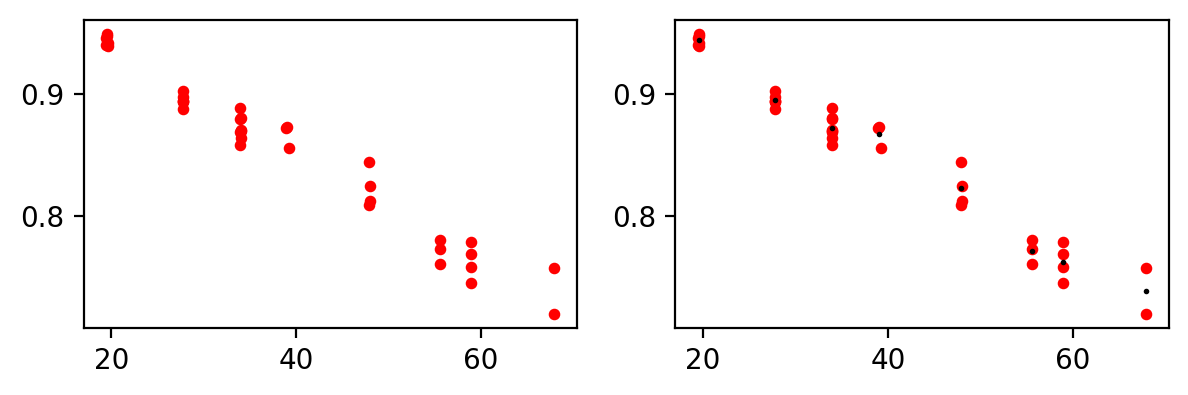

In [24]:
levels = np.arange(0,0.65,0.05)

xs, ts = np.meshgrid(xscales_km, tscales_INTER)
xsn, tsn = np.meshgrid(xscales_EXTRA, tscales_INTER)

fig = plt.figure(figsize=(7,2),dpi=200)
gs = gridspec.GridSpec(1,2)

ax1 = plt.subplot(gs[0, 0])
plt.scatter(vdist, vcorr, s=10, color='r')

ax1 = plt.subplot(gs[0, 1])
plt.scatter(vdist, vcorr, s=10, color='r')
plt.scatter(vdist_ave, vcorr_ave, s=1, color='k')

In [ ]:
from scipy.integrate import nquad
from pathos.multiprocessing import ProcessingPool as Pool
from scipy.optimize import differential_evolution

def nabla_2d(par_acf, myacf, T1, T2, err_min=1e-2):
    '''Original function'''
    if (T1 == 0) or (T2 == 0):
        print('integration domain is zero')
        return 0.0
    else:
        fun_XY = lambda x, y: (T1 - x) * (T2 - y) * myacf(x, y, par_acf)
        myint, myerr = nquad(fun_XY, [[0.0, T1], [0.0, T2]])
        return 4.0 * myint

def fast_corla_2d(par_acf, myacf, Tx, L, err_min=1e-2):
    '''Original function'''
    nab_1 = nabla_2d(par_acf, myacf, L, Tx[0], err_min=err_min)
    nab_2 = nabla_2d(par_acf, myacf, L, Tx[1], err_min=err_min)
    nab_3 = nabla_2d(par_acf, myacf, L, Tx[2], err_min=err_min)
    nab_den = nabla_2d(par_acf, myacf, L, L, err_min=err_min)
    if np.abs(nab_den) < 10e-6: # to avoid infinities
        # print('correcting - inf value')
        nab_den = 10e-6
    covla = 2*(nab_1 -2*nab_2 + nab_3)/(4*nab_den)
    # print('parhat =', par_acf)
    return covla

def epl_fun(x, epsilon, alpha):
    '''Original function'''
    x = np.asarray(x) # transform to numpy array
    is_scalar = False if x.ndim > 0 else True # create flag for output
    x.shape = (1,)*(1-x.ndim) + x.shape # give it dimension 1 if scalar
    m = np.size(x)
    myfun = np.zeros(m)
    for ii in range(m):
        if x[ii] < 10e-6:
            myfun[ii] = 1
        elif x[ii] < epsilon:
            myfun[ii] = np.exp(-alpha*x[ii]/epsilon)
        else:
            myfun[ii] = (epsilon/(np.exp(1)*x[ii]))**alpha
    myfun = myfun if not is_scalar else myfun[0]
    return  myfun

def myacf_2d(x, y, parhat, acf): #default acf = 'str'
    '''Original function'''
    d = np.sqrt(x**2 + y**2)
    if acf == 'str': # par d0, mu0
        d0 = parhat[0]
        mu = parhat[1]
        return np.exp( -(d/d0)**mu)
    elif acf == 'mar': # par:: epsilon, alpha
        # print('it actually is a Power Law')
        epsilon = parhat[0]
        alpha   = parhat[1]
        return epl_fun(d, epsilon , alpha)

def myfun_sse(xx, yobs, parhat, L, acf):
    '''Original function'''
    xx = np.asarray(xx)
    myacf = lambda x, y, parhat: myacf_2d(x, y, parhat, acf=acf)
    sse = 0
    m = np.size(xx)
    for ii in range(m):
        myx = xx[ii]
        Tx = np.array([np.abs(L - myx), myx, L + myx, myx])
        res = fast_corla_2d(parhat, myacf, Tx, L, err_min=1e-2)
        sse = sse + (res - yobs[ii]) ** 2
    return sse

def myfun(pardown):
        return myfun_sse(vdist_ave, vcorr_ave, pardown, PARAM['L1'], acf=PARAM['acf'])

In [ ]:
print('PARAMETERS FOR GAMMA')
start_time = time.time()

bounds = [(0.0, 25.0),(0, 0.3)]

with Pool(nodes=PARAM['cores']) as pool:
            resmin = differential_evolution(
            myfun,
            bounds,
            disp=True,
            tol=0.01,
            atol=0.01,
            workers=pool.map
    )

param1 = resmin.x[0]
param2 = resmin.x[1]
print(param1, param2)

end_time = time.time()
elapsed_time = end_time - start_time
elapsed_minutes = elapsed_time / 60
print()
print(f"Elapsed time: {elapsed_minutes:.2f} minutes")

PARAMETERS FOR GAMMA
differential_evolution step 1: f(x)= 0.002347092965082344
differential_evolution step 2: f(x)= 0.0019380133783631318
differential_evolution step 3: f(x)= 0.0019380133783631318
differential_evolution step 4: f(x)= 0.0019380133783631318
Polishing solution with 'L-BFGS-B'
24.600669681433494 0.18796094057081172

Elapsed time: 1.96 minutes


In [39]:
print(param1, param2)

24.600669681433494 0.18796094057081172


In [43]:
from scipy.integrate import dblquad
from scipy.special import gamma
from scipy.optimize import fsolve


def str_exp_fun(x, d0, mu):
    '''
    Stretched exponential rainfall correlation function
    from eg Habib and krajewski (2003)
    or Villarini and Krajewski (2007)
    with 2 parameters d0, mu (value as x = 0 is 1)
    '''
    x = np.asarray(x) # transform to numpy array
    is_scalar = False if x.ndim > 0 else True # create flag for output
    x.shape = (1,)*(1-x.ndim) + x.shape # give it dimension 1 if scalar
    myfun = np.exp( -(x/d0)**mu)
    myfun = myfun if not is_scalar else myfun[0]
    return  myfun

def vrf(L, L0, par_acf, acf):
    '''-------------------------------------------------------------
    compute the variance reduction factor
    between scales L (large) and L0 (small)
    defined as Var[L]/Var[L0]
    INPUT:
        L [km]
        L0 [Km]
        parhat = tuple with ACF parameters (eg epsilon, alpha)
        acf='mar' type of acf (mar or str available)
    OUTPUT:
        gam, variance reduction factor
        ---------------------------------------------------------'''
    def myacf(x, y, parhat, acf):
        if acf == 'str':  # par d0, mu0
            return str_exp_fun(np.sqrt(x ** 2 + y ** 2), parhat[0], parhat[1])
        elif acf == 'mar':  # par:: epsilon, alpha
            return epl_fun(np.sqrt(x ** 2 + y ** 2), parhat[0], parhat[1])
        else:
            print('vrf ERROR: insert a valid auto correlation function')
    # compute variance reduction factor
    fun_XY = lambda x, y: (L - x) * (L - y) * myacf(x, y, par_acf, acf)
    fun_XY0 = lambda x, y: (L0 - x) * (L0 - y) * myacf(x, y, par_acf, acf)
    # its 2D integral a-la Vanmarcke
    int_XY, abserr   = dblquad(fun_XY,  0.0, L,  lambda x: 0.0, lambda x: L)
    int_XY0, abserr0 = dblquad(fun_XY0, 0.0, L0, lambda x: 0.0, lambda x: L0)

    # gam  = 4/L**4 * int_XY # between scale L and a point
    # gam = (L0 / L) ** 4 * (int_XY / int_XY0)  # between scales L and L0
    if L0 == 0:
        gam = 4/L**4 * int_XY
    else:
        gam = (L0 / L)** 4 * (int_XY / int_XY0) 
    
    return gam

def down_wei(Ns, Cs, Ws, L, L0, beta, par_acf, acf):
    Ns = np.asarray(Ns)  # check if scalar input - should be the same for N,C,W
    Cs = np.asarray(Cs)
    Ws = np.asarray(Ws)
    # the three parameter mush have same shape - I only check one here
    is_scalar = False if Cs.ndim > 0 else True
    Ns.shape = (1,) * (1 - Ns.ndim) + Ns.shape
    Cs.shape = (1,) * (1 - Cs.ndim) + Cs.shape
    Ws.shape = (1,) * (1 - Ws.ndim) + Ws.shape
    m = Cs.shape[0]  # length of parameter arrays = number of blocks=
    gam = vrf(L, L0, par_acf, acf=acf)
    print(f'Gamma value: {gam}')

    # prob wet:: correct satellite N adding the average difference
    pws = np.mean(Ns) / 365.25
    Wd = np.zeros(m)
    Cd = np.zeros(m)
    Nd = np.zeros(m)
    for ii in range(m):
        cs = Cs[ii]
        ws = Ws[ii]
        rhs = (1/(gam*beta)) * (((2*ws*gamma(2 / ws))/((gamma(1/ws))**2)) + (gam-1)*pws)
        wpfun = lambda w: (2*w*gamma(2 / w)/(gamma(1/w))**2) - rhs

        res = fsolve(wpfun, 0.1, full_output=True,xtol=1e-06, maxfev=10000)
        
        Wd[ii] = res[0]
        info = res[1]
        fval = info['fvec']
        if fval > 1e-5:
            print('warning - downscaling function:: '
                    'there is something wrong solving fsolve!')
        Cd[ii] = (beta * Wd[ii]) * (cs / ws) * (gamma(1 / ws) / gamma(1 / Wd[ii]))
        Nd[ii] = int( np.rint( Ns[ii] / beta))

    # If Nd, Cd, Wd are a collection (example, list or array) and not a scalar, 
    # return all collection.
    Nd = Nd if not is_scalar else Nd[0]
    Cd = Cd if not is_scalar else Cd[0]
    Wd = Wd if not is_scalar else Wd[0]

    return Nd, Cd, Wd, gam, fval

In [44]:
print('WEIBULL PARAMETERS')
start_time = time.time()
NYd, CYd, WYd, gamYd, _ = down_wei(
                        ([20, 50, 20, 10]), 
                        ([2, 5, 2, 8]), 
                        ([0.20, 0.50, 0.20, 0.10]), 
                        PARAM['L1'], 
                        PARAM['L0'], 
                        beta, 
                        (param1, param2), 
                        acf=PARAM['acf'])
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

WEIBULL PARAMETERS
Gamma value: 0.9062394866173771
Elapsed time: 0.03 seconds
